TP 2 - Echantillonnage compressif
==================

In [1]:
import numpy as np
import numpy.linalg as npl
import math
import scipy.fftpack as fft
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets
%matplotlib inline

Récemment (début années 2004-présent), de nouveaux concepts et théorèmes ont été développés et risquent de 
révolutionner à relativement court terme la fabrication de certains appareils de mesure numériques (microphones, imageurs, analyseurs de spectres,...). 
Ces nouvelles techniques sont couramment appelées échantillonnage compressif, "compressive sampling" ou encore "compressed sensing". 

## 1. Le théorème de Shannon

Aujourd'hui, presque tous les appareils de mesure reposent sur le théorème de Shannon. Celui-ci (vous l'avez déjà vu en 2ème année) peut s'énoncer ainsi : 
> Soit $g:\mathbb{R}\to \mathbb{R}$ une fonction de $L^2(\mathbb{R})$. Si sa transformée de Fourier $\hat g$ a un support contenu dans l'intervalle $[-f_M, f_M]$, alors en l'échantillonnant à une fréquence d'échantillonnage $f_e\geq 2f_M$, on peut la reconstruire exactement.

Ce théorème est illustré sur les figures ci-après:
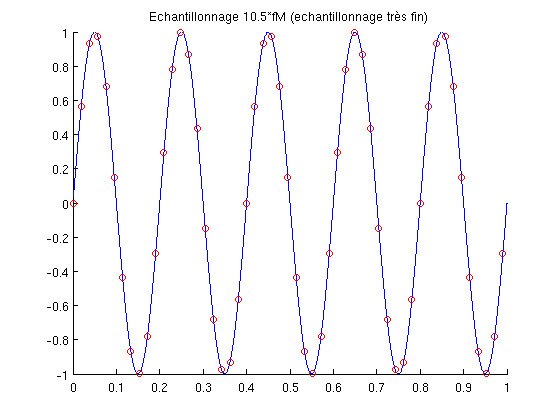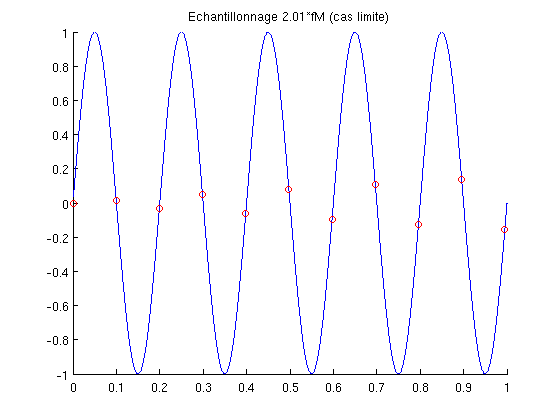
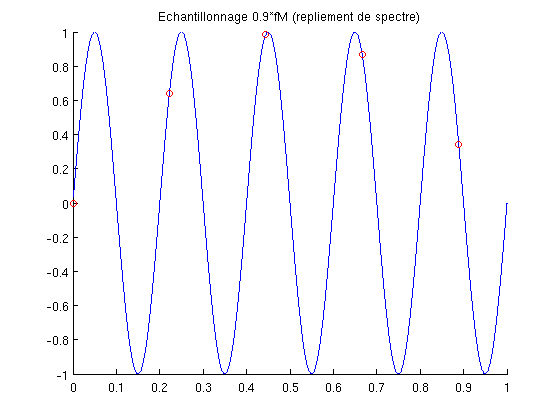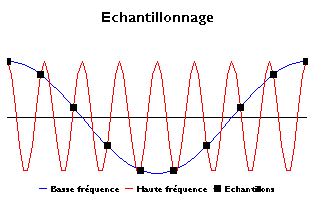

Les instruments de mesures qui reposent sur ce théorème sont donc construits suivant le principe : 
>Filtre passe-bas $\rightarrow$ Echantillonnage à une fréquence $f>2f_M$ $\rightarrow$ Interpolation sinc

Pour beaucoup d'applications, ce principe présente deux défauts majeurs :
* Les signaux sont rarement naturellement à spectre borné, et on perd donc l'information haute-fréquence en effectuant un filtrage passe-bas.
* Pour beaucoup de signaux, il faut choisir une très haute fréquence d'échantillonnage pour obtenir un résultat satisfaisant. 
Ceci implique que les données à stocker ont une taille très importante et qu'il faut les compresser après coup (par exemple : jpeg).




## 2. L'échantillonnage compressif

**1. Principe général**

L'idée sous jacente à l'échantillonnage compressif est de réaliser la compression dès l'acquisition.
Supposons que le signal $x\in \mathbb{R}^n$ que l'on souhaite mesurer s'écrive comme une combinaison linéaire de la forme :
\begin{equation}
(1)~~~~~~~~~~~ x=\sum_{i=1}^m\alpha_i \psi_i
\end{equation}
où $\psi_i\in \mathbb{R}^n, \ i=1..m$, sont des "fonctions de base" (en traitement d'images, ces fonctions pourraient être des ondelettes, en traitement du son, des ondelettes ou des atomes de Fourier, pour certaines applications, on pourrait imaginer des splines...} et $\alpha_i\in \mathbb{R}$ sont des coefficients. 
On peut réécrire l'équation (1) sous la forme matricielle condensée :
$$
x=\Psi \alpha \ \ \textrm{où } \ \ \alpha=\begin{pmatrix} \alpha_1 \\ \vdots \\ \alpha_m \end{pmatrix}\ \ \textrm{et} \ \ \Psi=\begin{pmatrix} \psi_1,\psi_2,..., \psi_m\end{pmatrix}.
$$
Pour pouvoir reconstruire tous les éléments de $\mathbb{R}^n$, on suppose généralement que la matrice $\Psi$ est une matrice surjective (ainsi, la famille  des $(\Psi_i)_i$ est génératrice), ce qui implique que $m\geq n$. Dans le langage du traitement d'image, on dit alors que $\Psi$ est un frame (une base si $m=n$).

L'échantillonnage compressif repose sur l'hypothèse suivante : les signaux $x$ que l'on souhaite mesurer sont parcimonieux, 
c'est-à-dire que la majorité des coefficients $\alpha_i$ dans (1) sont nuls ou encore que 
$$\#\{\alpha_i\neq 0, i=1..m\}\ll n.$$
On va voir que cette hypothèse permet - dans certains cas - de réduire drastiquement le nombre de mesures par rapport au théorème de Shannon avec en contre-partie, le besoin de résoudre un problème d'optimisation pour reconstruire la donnée. L'objectif de ce TP est de résoudre le problème d'optimisation résultant.

Le principe de l'acquisition du signal $x$ est le suivant :

- On effectue un petit nombre $p\ll n$ de mesures linéaires du signal $x$ inconnu. On note ces mesures $y_i$, et comme elles sont linéaires par rapport à $x$, il existe pour chaque $i$ un vecteur $a_i\in \mathbb{R}^n$ tel que 
$$y_i=\langle a_i, x\rangle, i=1..p.$$ On peut aussi écrire cette opération de mesure sous la forme condensée :
$$
y=Ax\ \ \textrm{où } \ \ y=\begin{pmatrix} y_1 \\ \vdots \\ y_p\end{pmatrix} \ \ \textrm{et} \ \ A=\begin{pmatrix} a_1^T\\a_2^T\\ \vdots
\\ a_p^T\end{pmatrix}.
$$
- On reconstruit le signal $x$ en résolvant le problème contraint suivant :

$$
(2)~~~~~~~~~~~ \mbox{Trouver } \alpha^\star \mbox{ solution de: }\displaystyle\min_{\alpha \in \mathbb{R}^m, A\Psi\alpha=y} \|\alpha\|_0
$$

où $\|\cdot\|_0$ est la norme de comptage, aussi appelée norme $l^0$ définie par : 
$$
\|\alpha\|_0=\#\{\alpha_i\neq 0, i=1..m\}.
$$
Autrement dit, l'idée est la suivante : on  cherche $\alpha^\star$, le signal le plus parcimonieux dans le frame $\Psi$, parmi les signaux qui peuvent donner lieu aux mesures $y$. 
Après avoir trouvé $\alpha^\star$, on recouvre $\tilde x$, une approximation du signal $x$ en calculant $\tilde x=\Psi\alpha^\star$.



**2. Simplification du problème d'optimisation**

Le problème précédent est un problème combinatoire NP-complet, ce qui signifie que trouver $\alpha$ peut demander un temps exponentiel en fonction de $n$, la dimension du signal. Pour le résoudre en pratique, il est souvent remplacé par : 

$$
(3)~~~~~~~~~~~  \mbox{Trouver } \alpha^*\in \displaystyle\arg\min_{\alpha \in \mathbb{R}^m, A\Psi\alpha=y} \|\alpha\|_1
$$

où $\|\alpha\|_1=\sum_{i=1}^m|\alpha_i|$ est la norme $l^1$ de $\alpha$. On peut dans certains cas montrer que les solutions de (2) et de (3) sont identiques. 

Un appareil de mesure n'étant jamais parfait, il est impossible de mesurer exactement $y_i=\langle a_i, x\rangle$. 
Le vecteur $y$ est bruité et la contrainte $A\Psi\alpha=y$ est trop forte. Elle est donc généralement relaxée et le problème devient : 

>$$(4)~~~~~~~~~~~  \mbox{Trouver } \alpha^*\in \arg\min_{\alpha \in \mathbb{R}^m} \|\alpha\|_1 + \frac{\sigma}{2} \|A\Psi\alpha-y\|_2^2.$$

Si $\sigma$ tend vers $0$, la solution du problème (4) tend vers une solution du problème (3). C'est le problème (4) que nous allons résoudre dans ce TP. Dans la suite , on notera $F$ la fonction :
$$
F(\alpha)=\|\alpha\|_1 + \frac{\sigma}{2} \|A\Psi\alpha-y\|_2^2.
$$

Pour conclure cette introduction à l'échantillonnage compressif, notons que de façon similaire au théorème de Shannon, on dispose d'une condition de reconstruction exacte :

> Supposons que :
* $x=\displaystyle\sum_{i=1}^m\alpha_i\psi_i\in \mathbb{R}^n$ avec $\|\alpha\|_0=k$.
* On effectue $p$ mesures linéaires de $x$ avec $p\geq C \cdot k \cdot \log(n)$, où $C=20$.
* On choisit les coefficients de la matrice $A\in \mathcal{M}_{p,n}$ de façon **aléatoire** (e.g. on peut choisir les coefficients $a_{i,j}$ de $A$ de façon indépendante suivant une loi normale.)

> Alors, la résolution du problème (3) permet de reconstruire $x$ **exactement** avec une très grande probabilité 

L'expérience a montré qu'en pratique, il suffit en général de $p=2k$ mesures pour reconstruire le signal exactement en grande dimension !

3. Préliminaires théoriques
----------------------------

Commençons par remarquer que les problèmes (3) et (4) sont convexes (contraintes convexes et fonctions convexes) tandis que le problème (2) ne l'est pas. En revanche, aucun des trois problèmes n'est différentiable.

**Q1.** Soit $J(\alpha) =\frac{\sigma}{2}\|A\Psi \alpha - y\|_2^2$. Calculez $\nabla J(\alpha)$.

$$\nabla J(\alpha) = \sigma \Psi^\top A^\top \left(A\Psi \alpha - y\right) $$


**Q2.** Montrer que la fonction $J$ est de classe $C^1$ à gradient Lipschitz et calculer un majorant $L$ de la constante de Lipschitz de $\nabla J$ en fonction de $|||A|||$, de $|||\Psi |||$ et de $\sigma$.
    
$J$ est continue et $\nabla J$ existe et est continue donc $J$ est de classe $C^1$. 
De plus, $\nabla J$ est différentiable donc par le théorème des accroissements finis,
$$
 \forall (x,y), \| \nabla J(x) - \nabla J(y) \| \leq |||H_J(u)||| \times \|x - y\| $$
 
 avec 

$$ |||H_J(u)||| = \sigma |||A|||^2 \times |||\Psi|||^2 $$


Donc $J$ est à gradient Lipschitz.
    

**Construction de l'algorithme**

On note $\alpha^k$ l'itéré courant. En appliquant le lemme de Nesterov à la fonction $J$, on a:
$$\forall \alpha\in \mathbb{R}^m,~J(\alpha)\leq {J(\alpha^k) + \langle \nabla J(\alpha^k), \alpha-\alpha^k\rangle + \frac{L}{2}\|\alpha-\alpha^k\|_2^2}.
$$

En posant $\phi(\alpha,\alpha^k)=J(\alpha^k) + \langle \nabla J(\alpha^k), \alpha-\alpha^k\rangle + \frac{L}{2}\|\alpha-\alpha^k\|_2^2 +\|\alpha\|_1$, on a alors:

$$\forall \alpha\in \mathbb{R}^m,~F(\alpha) = J(\alpha)+\|\alpha\|_1\leq \phi(\alpha,\alpha^k),$$

avec : $\phi(\alpha^k,\alpha^k) = F(\alpha^k)$.

Cette inégalité motive alors l'algorithme de descente suivant:

$$\alpha^{k+1}=\displaystyle\arg\min_{\alpha\in \mathbb{R}^m} \phi(\alpha,\alpha^k).$$

**Q3.** Montrer que l'algorithme s'écrit de façon équivalente sous la forme:
$$\alpha^{k+1} = \mbox{prox}_{\frac{1}{L}\|\cdot\|_1}\left(\alpha^k - \frac{1}{L}\nabla J(\alpha^k)\right).$$


$$\begin{align}
\alpha^{k+1} &= \arg\min_{\alpha \in \mathbb{R}^m} \Phi(\alpha, \alpha^k) \\
&= \arg\min_{\alpha \in \mathbb{R}^m} J(\alpha^k) + \langle \nabla J(\alpha^k), \alpha - \alpha^k \rangle + \frac{L}{2} \| \alpha - \alpha^k \|_2^2 + \| \alpha \|_1 \\
&= \arg\min_{\alpha \in \mathbb{R}^m} J(\alpha^k) + \frac{L}{2} \left( \| \alpha - \alpha^k \|_2^2 + \frac{2}{L} \langle \nabla J(\alpha^k), \alpha - \alpha^k \rangle \right) + \| \alpha \|_1 \\
&= \arg\min_{\alpha \in \mathbb{R}^m} J(\alpha^k) + \frac{L}{2} \| \alpha - \alpha^k  + \frac{1}{L} \nabla J(\alpha^k) \|_2^2 - \frac{1}{L^2} \| \nabla J(\alpha^k) \|_2^2 + \| \alpha \|_1 \\
&= \arg\min_{\alpha \in \mathbb{R}^m}\| \alpha \|_1 + \frac{L}{2} \| \alpha - \alpha^k  + \frac{1}{L} \nabla J(\alpha^k) \|_2^2  \\
& \text{car $\alpha^k$ et donc $J(\alpha^k)$ sont constants, ie ne dépendent pas de $\alpha$}
\end{align}$$

Or, 
$$\begin{align}
\mbox{prox}_{\frac{1}{L}\|\cdot\|_1}\left(\alpha^k - \frac{1}{L}\nabla J(\alpha^k)\right) &= \arg\min_{\alpha \in \mathbb{R}^m} \frac{1}{L} \| \alpha \|_1 + \frac{1}{2} \| \alpha - \alpha^k + \frac{1}{L} \nabla J(\alpha^k) \|_2^2 \\
&= \arg\min_{\alpha \in \mathbb{R}^m} \| \alpha \|_1 + \frac{L}{2} \| \alpha - \alpha^k + \frac{1}{L} \nabla J(\alpha^k) \|_2^2 \quad \text{ puisque $L \geq 0$}
\end{align}$$

On a donc bien l'équivalence entre ces deux problèmes.

**Q5.** De quelle quantité la fonction coût $F(\alpha)$ décroît-elle à chaque itération ?


**Première version**
On a vu qu'on pouvait écrire $F$ comme la somme de deux fonctions convexes, l'une semi-continue inférieurement (c'est $\|\cdot\|_1$), et l'autre à gradient Lipschitz (c'est $J$). Le lemme d'inégalité globale nous dit : 
$$\forall t \in \left ]0, \frac{1}{L} \right], \forall (\alpha,z) \in \mathbb{R}^n \times \mathbb{R}^n, \\
F(\alpha - tG_t(\alpha)) \leq F(z) + \langle G_t(\alpha), \alpha - z \rangle - \frac{t}{2} \| G_t(\alpha)\|_2^2
$$
où $$G_t(\alpha) = \frac{1}{t} (\alpha - \mbox{prox}_{th}(\alpha - t \nabla g(\alpha)) $$ avec $g$ la fonction convexe à gradient Lipschitz et $h$ la fonction convexe sci.

Ici, on prend $t=\frac{1}{L}$ comme on l'a vu au dessus pour définir notre itéré $\alpha_{k+1}$; $g = J$ et $h = \|\cdot\|_1$. On pose de plus $\alpha = \alpha_k$. Soit $\alpha_{k+1} = \alpha_k - \frac{1}{L} G_\frac{1}{L}(\alpha_k)$ et $z =\alpha_k$.
On a alors

$$\begin{align}
\alpha_{k+1} &= \alpha_k - \alpha_k + \mbox{prox}_{\frac{1}{L} \|\cdot\|_1}\left(\alpha_k - \frac{1}{L} \nabla J(\alpha_k)\right) \\
&= \mbox{prox}_{\frac{1}{L} \|\cdot\|_1}\left(\alpha_k - \frac{1}{L} \nabla J(\alpha_k)\right)
\end{align}$$
C'est bien le $\alpha_{k+1}$ défini un peu plus haut pour notre algorithme.

En réinjectant ces variables dans l'inégalité globale on obtient :
$$
F(\alpha_{k+1}) \leq F(\alpha_k) - \frac{1}{L} \| G_\frac{1}{L} (\alpha_k)\|_2^2 \\
\Leftrightarrow  F(\alpha_{k+1}) - F(\alpha_k) \leq - \frac{1}{L} \| G_\frac{1}{L} (\alpha_k)\|_2^2
$$

On voit donc clairement que $F(\alpha_{k+1}) - F(\alpha_k) \leq 0$ : notre algorithme est bien un algorithme de descente.



**Ou bien alors version de Louis**

On a vu qu'on pouvait écrire $F$ comme la somme de deux fonctions : $F(\alpha) = J(\alpha) + \|\alpha\|_1$ .

$J$ est une fonction convexe à gradient L-Lipschitz, c'est à dire que $\forall (x,y) \in \mathbb{R}^n \times \mathbb{R}^n $ :  
$$J(y) \leq J(x) + \langle \nabla J(x), y-x \rangle + \frac{L}{2} \|y-x\|^2_2$$  

Dans notre cas, en prenant $y = \alpha_{k+1}$ et $x = \alpha_k$, on obtient
$$\begin{align}
& J(\alpha_{k+1}) \leq J(\alpha_{k}) + \langle \nabla J(\alpha_{k}), \alpha_{k+1}-\alpha_{k} \rangle + \frac{L}{2} \|\alpha_{k+1}-\alpha_{k}\|^2_2 \\
\Leftrightarrow & J(\alpha_k) \geq J(\alpha_{k+1}) + \langle \nabla J(\alpha_k), \alpha_k - \alpha_{k+1} \rangle - \frac{L}{2}\|\alpha_{k+1} - \alpha_k\|^2_2\\
\Leftrightarrow & \frac{1}{L} J(\alpha_k) \geq \frac{1}{L} J(\alpha_{k+1}) + \frac{1}{L} \langle \nabla J(\alpha_k), \alpha_k - \alpha_{k+1} \rangle - \frac{1}{2}\|\alpha_{k+1} - \alpha_k\|^2_2 \text{ : notée $(E1)$}
\end{align}$$

On pose $h(\alpha)=||\alpha||_1$. $h$ est une fonction convexe sci.
On sait que 
$$\begin{align}
\alpha_{k+1} &= \mbox{prox}_{\frac{1}{L}h}\left(\alpha_k - \frac{1}{L}\nabla J(\alpha_k)\right) \\
&= \arg \min_{y \in \mathbb{R}}\frac{1}{L}h(y)+ \frac{1}{2}||y - \alpha_k + \frac{1}{L} \nabla J(\alpha_k)||^2_2\\ 
\end{align}
$$

La condition d'optimalité de ce problème s'écrit :
 
$$\begin{align}
& 0 \in \left\{\frac{1}{L}\partial h(\alpha_{k+1}) + \alpha_{k+1} - \alpha_k + \frac{1}{L}\nabla J(\alpha_k)\right\} \\
\Leftrightarrow & \alpha_{k+1}-\alpha_k +\frac{1}{L}\nabla J(\alpha_k) \in \frac{1}{L}\partial h(\alpha_{k+1}) \\
\Leftrightarrow & \frac{1}{L} h(y) \geq \frac{1}{L} h(\alpha_{k+1}) + \langle \alpha_k - \frac{1}{L}\nabla J(\alpha_k)-\alpha_{k+1} , y - \alpha_{k+1} \rangle , \forall y \in \mathbb{R}^n \text{, par définition du sous-différentiel.}
\end{align}$$
  
Si on pose $y=\alpha_k$, cette inégalité devient :
$$\begin{align}\frac{1}{L} h(\alpha_k) &\geq \frac{1}{L} h(\alpha_{k+1}) +\langle \alpha_k - \frac{1}{L}\nabla J(\alpha_k) - \alpha_{k+1}, \alpha_k - \alpha_{k+1} \rangle\\
&\geq \frac{1}{L} h(\alpha_{k+1}) - \frac{1}{L}\langle \nabla J(\alpha_k), \alpha_k - \alpha_{k+1}\rangle + \|\alpha_k - \alpha_{k+1}\|_2^2 \text{ : notée $(E2)$}
\end{align}$$  


En sommant $(E1)$ et $(E2)$, on obtient :   

$$\begin{align}
&\frac{1}{L} J(\alpha_k) + \frac{1}{L} h(\alpha_k) \geq \frac{1}{L} J(\alpha_{k+1}) + \frac{1}{L}h(\alpha_{k+1}) +\frac{1}{L} \langle \nabla J(\alpha_k), \alpha_k - \alpha_{k+1} \rangle - \frac{1}{L} \langle \nabla J(\alpha_k), \alpha_k - \alpha_{k+1} \rangle + \|\alpha_{k+1} - \alpha_k\|^2_2 - \frac{1}{2}\|\alpha_{k+1} - \alpha_k\|^2_2\\
\Leftrightarrow &\frac{1}{L} F(\alpha_k) \geq \frac{1}{L} F(\alpha_{k+1}) + \frac{1}{2}\|\alpha_{k+1} - \alpha_k\|^2_2 \text{ , puisque $F = J +h$}\\
\Leftrightarrow & F(\alpha_k) \geq F(\alpha_{k+1}) + \frac{L}{2}\|\alpha_{k+1} - \alpha_k\|^2_2 \\
\Leftrightarrow & F(\alpha_k) - F(\alpha_{k+1}) \geq  \frac{L}{2}\|\alpha_{k+1} - \alpha_k\|^2_2 \geq 0
\end{align}$$

On voit donc clairement que  $F(\alpha_k) \geq F(\alpha_{k+1})$ ce qui signifie que la fonction coût décroit à chaque itération : c'est bien un algorithme de descente.

4. Partie expérimentale
------------------------

Dans ce TP, on va chercher à reconstruire un signal unidimensionnel $x~:~[0,1]~\rightarrow~\mathbb{R}$ de la forme :
$$
x(t)= \alpha_{k}\delta_{k/n}(t)+\sum_{k=1}^n\alpha_{k+n}\cos\left(\frac{2k\pi}{n} t\right)
$$ 
on a donc $m=2n$.

In [2]:
## Initialisations
def Init(n, p, plot=False):
    t= np.linspace(0, 1, n) #On definit un signal sur [0,1]

    ## Generation du signal
    x = np.zeros(n)
    tmp = np.zeros(n)
    #On ajoute deux cosinus
    tmp[350] = 4
    x += fft.idct(tmp, norm='ortho')  
    tmp = np.zeros(n)
    tmp[150] = -3  
    x += fft.idct(tmp, norm='ortho')
    #On ajoute deux diracs
    x[int(n/3)] = 0.2    #Tester 0.5
    x[int(2*n/3)] = -0.3 #Tester -1
    
    if plot:
        plt.plot(t, x, 'b')
        plt.show()
    ## Mesure du signal
    A = np.random.randn(p, n) #La matrice de mesure
    y = A.dot(x)        #Les mesures
    return A, y, x, n

Le code *Generesignal.py* génère un signal discret $x$ qui peut être vu comme une combinaison linéaire de cosinus à différentes fréquences et de diracs. Ce signal n'est pas parcimonieux dans la base canonique des diracs (car il faut à peu près $n$ diracs pour représenter un cosinus) et il n'est pas parcimonieux dans la base des sinus (il faut faire une combinaison linéaire de $n$ cosinus pour représenter un dirac).

Par contre, ce signal est parcimonieux dans un frame qui est l'union de la base canonique et de la base des cosinus. 
Dans ce frame, il suffit en effet de $4$ coefficients non nuls pour reconstruire parfaitement le signal.

> On choisira donc le frame représenté par une matrice $\Psi=(I,C) \in \mathcal{ M}_{2n,n}(\mathbb{R})$ o\`u $C$ est une base de cosinus à différentes fréquences.

### 4.1. Implémentation de l'itération proximale

**Q6** Implémentez l'opérateur linéaire $\Psi$ et son adjoint $\Psi^*$. 

Pour $\Psi$, vous vous servirez de la fonction $dct$ de Python dans la libraire scipy.fftpack qui calcule la transformée en cosinus discret d'un vecteur. Vous ferez attention à préciser *norm='ortho'* dans les options de la $dct$ pour que $idct$ soit bien l'opération inverse de $dct$.

Pour $\Psi^*$, vous utiliserez le fait que la $dct$ est une isométrie quand on précise \textit{norm='ortho'} dans les options de $dct$.

**R** 
$dct$ et $idct$ sont des isométries donc $(idct)^* = dct$. Ainsi, puisque $\Psi(\alpha)_i=\alpha_i + idct((\alpha_i)_{n+1\leq i\leq 2n})_{i+n} \forall i \in {1...n}$, on obtient :
$$\Psi^*=\begin{pmatrix} I^* \\ C^*\end{pmatrix}=\begin{pmatrix} I \\ C^*\end{pmatrix}$$

In [3]:
## Linear function Psi
## (combination of sines and diracs) 
def Psi(alpha):
    n = len(alpha) // 2
    x = np.zeros(n)
    x[:n] = alpha[:n] + fft.idct([alpha[n:]], norm='ortho', axis=-1, overwrite_x=False)
    return x


## The transpose of Psi
def PsiT(x): 
    n = len(x)
    alpha = np.zeros(2 * n)
    alpha[:n] = x
    alpha[n:] = fft.dct(x, norm='ortho', axis=-1, overwrite_x=False)
    return alpha

**Q7** Implémentez l'algorithme proximal dans la fonction *RestoreX* avec les notations suivantes:
* $A$ est la matrice d'échantillonnage.
* $y$ est le vecteur de mesures.
* $sigma$ est un paramètre du modèle.
* $nit$ est le nombre d'itérations.
* $alpha$ est la solution approximative du problème (4).
* $x$ est donné par Psi $(\alpha)$.
* $CF$ est la fonction coût à chaque itération de l'algorithme. 

$$\alpha^{k+1} = \mbox{prox}_{\frac{1}{L}\|\cdot\|_1}\left(\alpha^k - \frac{1}{L}\nabla J(\alpha^k)\right).$$

$$
F(\alpha)=\|\alpha\|_1 + \frac{\sigma}{2} \|A\Psi\alpha-y\|_2^2.
$$

$$
\nabla J(\alpha) = \sigma \Psi^\top A^\top\left(A\Psi \alpha - y\right)
$$

In [4]:
## Prox of the l1−norm 
def prox(alpha, gamma):
    return np.sign(alpha) * np.maximum(np.abs(alpha) - gamma, 0)

def RestoreX(A, y, sigma, nit):
    alpha = np.zeros(np.shape(A)[1] * 2) 
    L = 2 * sigma * npl.norm(A, 2) ** 2  # La norme triple de Psi vaut 2
    CF = []
    alpha_k = np.zeros((nit, len(alpha)))
    cv_rate = np.zeros(nit-2)
    for i in range(nit):
        x = Psi(alpha)
        CF.append(npl.norm(alpha, 1) + sigma / 2 * (npl.norm(np.dot(A, x) - y)) ** 2)
        alpha = prox(alpha - 1 / L * sigma * PsiT(A.T.dot(A.dot(x) - y)), 1 / L)
        alpha_k[i,:] = np.copy(alpha)
      
    for j in range(len(cv_rate)):
        cv_rate[j] = npl.norm(alpha_k[j+1, :]-alpha, 2)/npl.norm(alpha_k[j, :]-alpha, 2)
    return alpha, x, CF, cv_rate[np.logical_not(np.isnan(cv_rate))]

**Q8.** Testez votre algorithme ! Les paramètres $sigma$ et $nit$ sont des paramètres à choisir par vous-même (il faut en pratique beaucoup d'itérations pour converger). Vous pourrez observer la façon dont la suite $\alpha^k$ se comporte au fur et à mesure des itérations.

In [5]:
@interact(sigma=widgets.FloatSlider(min=0.1, max=6, step=0.1, value=0.1, continuous_update=False), 
          nit=widgets.IntSlider(min=2500, max=50000, step=2500, value=2500, continuous_update=False))
def test_sigma_nit(sigma, nit):
    A, y, x, n = Init(500, 50)
    fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
    alpha, xtilde, CF, cv_rate = RestoreX(A, y, sigma, nit)

    ax[0, 0].plot(np.linspace(0, 1, 500), x)
    ax[0, 0].set_title("Signal original")

    ax[0, 1].plot(np.linspace(0, 1, 500), xtilde)
    ax[0, 1].set_title("Signal reconstruit")
    
    ax[1, 0].plot(CF)
    ax[1, 0].semilogy()
    ax[1, 0].set_title("Fonction coût")
    
    ax[1, 1].plot(alpha)
    ax[1, 1].set_title("Alpha pour nit : " + str(nit) + ", sigma : " + str(sigma))
    
    # reste à afficher cv_rate:
    ax[2,0].plot(cv_rate)
    ax[2,0].set_title('Taux de convergence')
    
    plt.show()
    print("Valeur finale de la fonction coût : ", CF[-1])

interactive(children=(FloatSlider(value=0.1, continuous_update=False, description='sigma', max=6.0, min=0.1), …

$\sigma$ est le paramètre qui correspond à l'attachement aux données. Plus il est grand et plus on s'accroche aux données. 

Si on veut une forte accroche aux données, il faut augmenter le nombre d'itérations pour converger.

On va visualiser l'évolution des coefficients $\alpha_k$ et du signal reconstitué selon le nombre d'itérations.

**Tester aussi pour les autres paramètres proposés dans Init.**

<IPython.core.display.Javascript object>


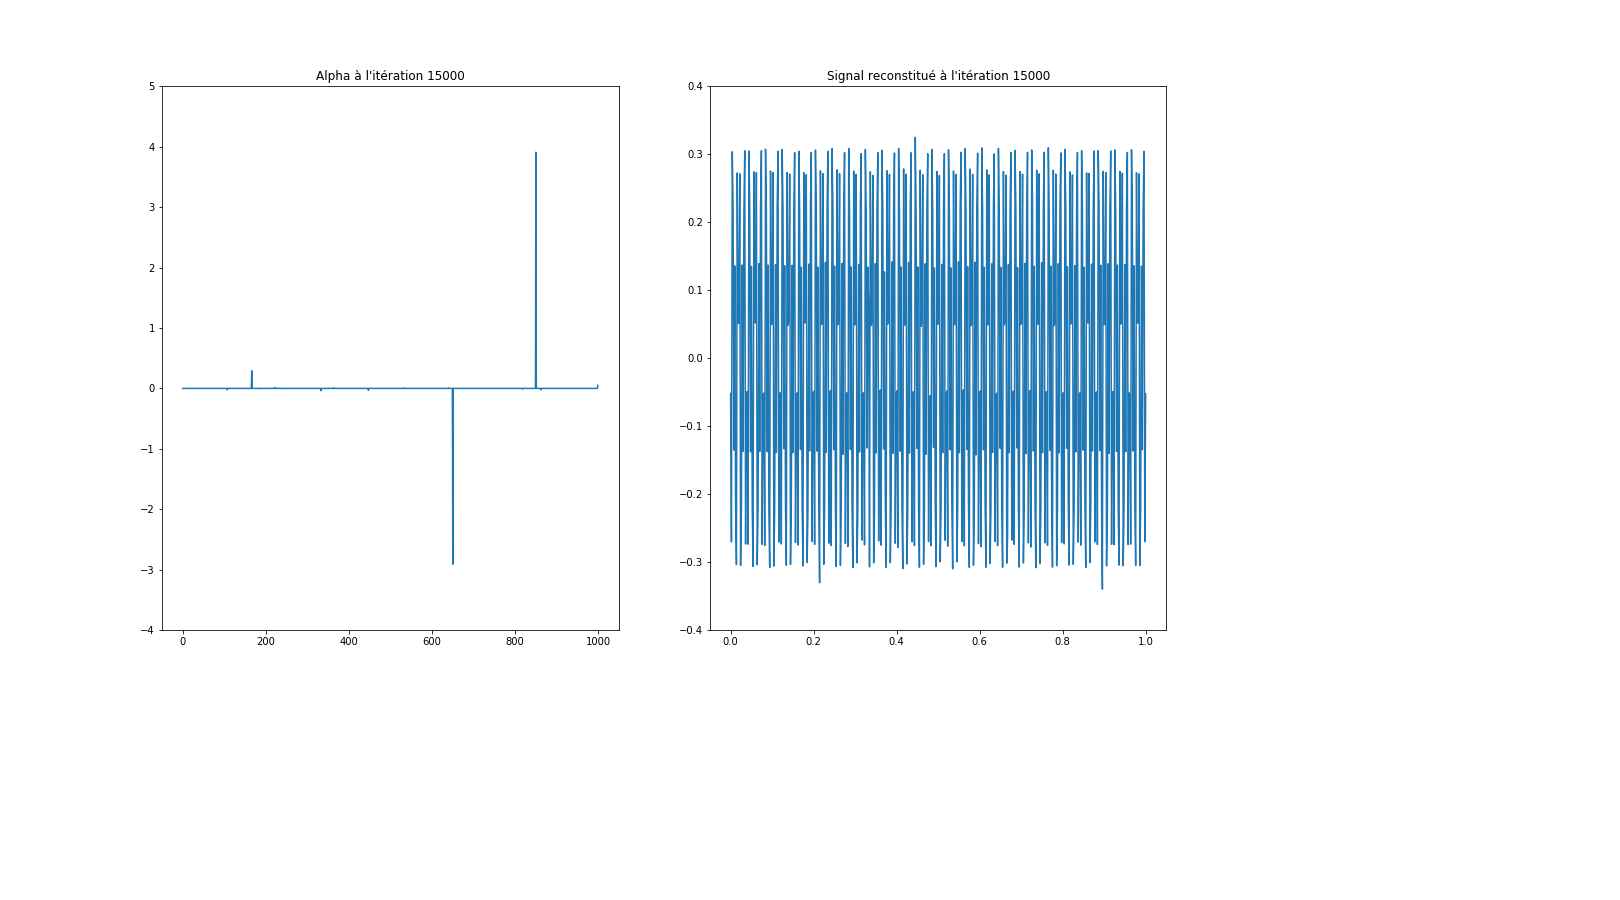

In [15]:
%matplotlib notebook
sigma = 1
p = 30
nit = 15000
A, y, x, n = Init(500, p)

alpha = np.zeros(np.shape(A)[1] * 2) 
L = 2 * sigma * npl.norm(A, 2) ** 2  # La norme triple de Psi vaut 2
CF = []
x_plot = np.linspace(0, 1, num=np.shape(A)[1])

plt.ion()  # Mode interactif on

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 10))
ax[0].set_ylim((-4, 5))
ax[1].set_ylim((-0.4, 0.4))

for i in range(nit + 1):
    x = Psi(alpha)
    CF.append(npl.norm(alpha, 1) + sigma / 2 * (npl.norm(np.dot(A, x) - y)) ** 2)
    alpha = prox(alpha - 1 / L * sigma * PsiT(A.T.dot(A.dot(Psi(alpha)) - y)), 1 / L)
    
    if i == 0:  # Création des plots
        line1, = ax[0].plot(range(alpha.shape[0]), alpha)
        line2, = ax[1].plot(x_plot, x)
        ax[0].set_title("Alpha à l'itération 1")
        ax[1].set_title("Signal reconstitué à l'itération 1")
        fig.canvas.draw()
        fig.canvas.flush_events()
        plt.pause(1)
    elif i % 25 == 0:  # Refresh du signal toutes les 25 itérations
        line1.set_ydata(alpha)
        ax[0].set_title("Alpha à l'itération " + str(i))
        line2.set_ydata(x)
        ax[1].set_title("Signal reconstitué à l'itération " + str(i))
        fig.canvas.draw()
        fig.canvas.flush_events()
        if i <= 2500:
            plt.pause(5 / i)
               
plt.ioff()
%matplotlib inline

Le résultat attendu pour alpha est composé de 4 pics, c'est-à-dire 4 coefficients non nuls, deux correspondant aux cosinus et deux correspondant aux diracs.

Sur cette animation on peut voir qu'à la première itération, tous les coefficients ont des valeurs non nulles mais proches de zéro. Ensuite, les coefficients à retrouver voient leur valeur augmenter, ce qui fait diminuer le terme $\frac{\sigma}{2} \|A\Psi\alpha-y\|_2^2$ de la fonction coût. Dans un second temps, on voit la valeur des autres coefficients se rapprocher de 0, ce qui minimise le terme $\|\alpha\|_1$ de la fonction coût.

On peut aussi visualiser l'influence du paramètre $\sigma$ : s'il est trop petit ($\sigma = 0.001$ pour $p = 30$), on échoue à reconstruire le signal, car la recherche de parcimonie du signal a trop d'influence face à l'attache aux données. On minimise donc la fonction coût en étant loin de la solution et en donnant des valeurs nulles aux coefficients. A l'inverse, une valeur de $\sigma$ élevée va entraîner une convergence lente. En effet, on va alors chercher en priorité à s'approcher de la valeur mesurée au détriment de la recherche de la parcimonie.  

**Q9**. Vérifiez que la fonction coût décroit de façon monotone. Quel est le taux de convergence observé ?

On observe approximativement que le nombre d'itérations nécessaires pour converger est d'environ $2500\sigma$, pour $p=150$. 

Le taux de convergence est la suite des itérés $\mu_k = \frac{\|x_{k+1} - x^*\|}{\|x_k - x^*\|}$, où $x^*$ désigne la limite vers laquelle converge la suite $x_k$.

**Q10.** A partir de combien de mesures pouvez-vous reconstruire exactement le signal $x$ ?

In [8]:
@interact(p=widgets.IntSlider(min=0, max=50, step=2, value=22, continuous_update=False), 
          sigma=widgets.FloatSlider(min=0.00, max=3, step=0.05, value=1, continuous_update=False))
def Test_nb_Mesure(p, sigma):   
    A, y, x, n = Init(500, p)
    nit = 80000
    alpha, xtilde, CF, cv_rate = RestoreX(A, y, sigma, nit)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.plot(alpha)
    ax1.set_title("Coefficients alpha pour p = " + str(p) + " et sigma = " + str(sigma))
    ax2.plot(np.linspace(0, 1, 500), xtilde)
    ax2.set_title("Signal reconstitué")
    plt.show()
    dif = npl.norm(x - xtilde)
    print("Différence entre le signal initial et reconstitué : ", dif)
    print("Valeur finale de la fonction coût : ", CF[-1])

interactive(children=(IntSlider(value=22, continuous_update=False, description='p', max=50, step=2), FloatSlid…

On fixe volontairement un `nit` assez grand (80000) car les itérations sont assez rapides à effectuer. En revanche si on peut diminuer considérablement le nombre de mesures effectuées (soit `p`), ça serait intéressant en pratique. On a fixé pour les tests un signal de 500 données au total.

On peut reconstruire le signal exactement pour $p = 22$. Il faut pour cela ajuster la valeur de $\sigma$, et une valeur de 1 semble être un bon choix pour $nit = 80000$.

Néanmoins, il semble préférable de réduire le nombre maximal d'itérations. On peut donc envisager de réduire également la valeur de $\sigma$ à XXXXXX A COMPLTER.

### 4.2. Implémentation de l'itération proximale accelérée

On n'a a aucun moment utilisé la convexité de la fonction $J$ pour définir l'algorithme proximal. Celui-ci est de fait sous-optimal et peut être nettement accéléré. Dans notre cas, l'algorithme accéléré (Nesterov 2007) suit le schéma suivant:

Paramètres en entrée:
* $N$ le nombre d'itérations
* $\alpha^0\in \mathbb{R}^m$ un point initial.

Algorithme
> Poser $B^0=0_\mathbb{R}$, $g^0=0_{\mathbb{R}^m}$, $\alpha=\alpha^0$
> For $k$= $0$ to $N$

>> $t= \frac{2}{L}$ 
>> $a^k = \frac{1}{2}\left(t+\sqrt{t^2+4t B^k}\right)$ 
>> $v^{k} =\mbox{prox}_{B^k\|\cdot\|_1}(\alpha^0-g^k)$ 

>> $w^k = \frac{B^k \alpha^k +a^k v^k}{B^k+a^k}$ 

>>  $\alpha^{k+1} = \mbox{prox}_{\frac{1}{L}\|\cdot\|_1}\left(w^k-\frac{\nabla J(w^k)}{L}\right)$  

>>	$g^{k+1} = g^k + a^k\nabla J(\alpha^{k+1})$ 

>>	$B^{k+1} = B^k+a^k$
 
**Q11.** En vous aidant de ce que vous avez codé dans la partie précédente, implémentez cet algorithme. 

In [43]:
def Nesterov(A, y, sigma, nit):
    B = 0
    g = np.zeros(np.shape(A)[1] * 2)
    alpha0 = np.zeros(np.shape(A)[1] * 2)
    L = 2 * sigma * npl.norm(A, 2) ** 2
    t = 2 / L
    CF = []
    alpha = np.zeros(np.shape(A)[1] * 2)
    alpha_k = np.zeros((nit, len(alpha)))
    cv_rate = np.zeros(nit-2)
    for k in range(nit):
        a = 1 / 2 * (t + np.sqrt(t ** 2 + 4 * t * B))
        v = prox(alpha - g, B)
        w = (B * alpha + a * v) / (B + a)
        grad_J_w =  sigma * PsiT(A.T.dot(A.dot(Psi(w)) - y))
        alpha = prox(w - grad_J_w / L, 1 / L)
        grad_J_alpha =  sigma * PsiT(A.T.dot(A.dot(Psi(alpha)) - y))
        g += a * grad_J_alpha
        B += a
        CF.append(npl.norm(alpha, 1) + sigma / 2 * (npl.norm(np.dot(A, Psi(alpha)) - y)) ** 2)
        alpha_k[k, :] = np.copy(alpha)
    x = Psi(alpha)
    for j in range(len(cv_rate) - 1):
        cv_rate[j] = npl.norm(alpha_k[j+1, :] - alpha, 2) / npl.norm(alpha_k[j, :] - alpha, 2)
    return alpha, x, CF, cv_rate 

**Q12.** Testez le et comparez la rapidité d'execution de l'algorithme précédent et de celui-ci.

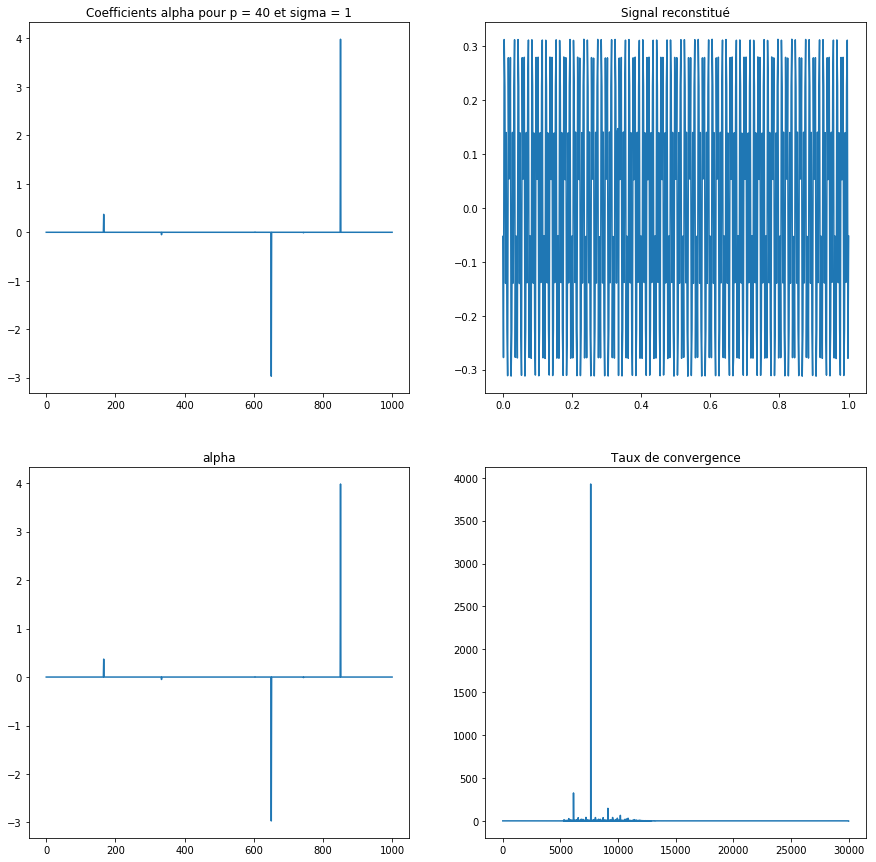

Différence entre le signal initial et reconstitué :  0.06903146741436804
Valeur finale de la fonction coût :  7.446688985237441


In [49]:
sigma = 1
p = 40
A, y, x, n = Init(500, p)
nit = 30000

alpha, xtilde, CF, cv_rate = Nesterov(A, y, sigma, nit)
fig, ax = plt.subplots(2, 2, figsize=(15, 15))
ax[0,0].plot(alpha)
ax[0,0].set_title("Coefficients alpha pour p = " + str(p) + " et sigma = " + str(sigma))

ax[0,1].plot(np.linspace(0, 1, 500), xtilde)
ax[0,1].set_title("Signal reconstitué")

ax[1,0].plot(alpha)
ax[1,0].set_title("alpha")

ax[1,1].plot(cv_rate)
ax[1,1].set_title("Taux de convergence")

plt.show()
dif = npl.norm(x - xtilde)
print("Différence entre le signal initial et reconstitué : ", dif)
print("Valeur finale de la fonction coût : ", CF[-1])

Le signal est bien reconstitué après un petit nombre d'itérations. 
Si on applique la première version de l'algorithme avec les mêmes paramètres, on observe qu'il n'a pas eu le temps de converger. La version accélérée est donc bien plus rapide. 

On remarque de plus que les paramètres optimaux sur ces deux algorithmes sont les mêmes. C'est tout à fait normal car l'algorithme accéléré se base sur les mêmes principes que l'algorithme proximal. Il prend juste en compte la convexité de notre fonction en plus.

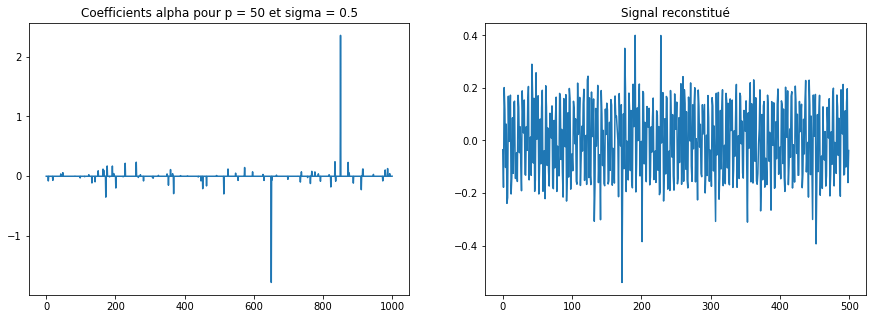

Différence entre le signal initial et reconstitué :  2.272424930986431
Valeur finale de la fonction coût :  11.343636204291247


In [11]:
sigma = 0.5
p = 50
A, y, x, n = Init(500, p)
nit = 1000

alpha, xtilde, CF, cv_rate = RestoreX(A, y, sigma, nit)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(alpha)
ax1.set_title("Coefficients alpha pour p = " + str(p) + " et sigma = " + str(sigma))
ax2.plot(xtilde)
ax2.set_title("Signal reconstitué")
plt.show()
dif = npl.norm(x - xtilde)
print("Différence entre le signal initial et reconstitué : ", dif)
print("Valeur finale de la fonction coût : ", CF[-1])

**Q13.** Faites un rapide résumé des points qui vous ont semblé les plus importants dans ce TP.

L'échantillonnage compressif est un moyen efficace de contourner le théorème de Shannon lorsque l'on souhaite reconstituer convenablement un signal. En effet d'après ce théorème et avec le signal étudié, il aurait fallu que notre fréquence d'échantillonnage soit supérieure à 700 Hz, puisque notre signal d'origine était composé d'une sinusoïde de fréquence 350 Hz. Cela représente donc un nombre trop important de mesures à effectuer (700 au minimum) pour être utilisé en pratique. 
A l'inverse, grâce à l'échantillonnage compressif, on a pu reconstituer un signal avec un nombre très faible de mesures. De plus même si le signal était irrégulier (à cause des deux diracs), l'échantillonnage compressif s'est révélé efficace dans la reconstruction de ce signal.

La méthode accélérée est beaucoup plus efficace que la méthode de l'algorithme proximal classique. En effet, pour 50 mesures et $\sigma = 1$, seulement 1000 itérations suffisent à faire converger l'algorithme proximal accéléré. En revanche, les mêmes paramètres ne permettent pas du tout de faire converger l'algorithme classique. 

Le choix de $\sigma$ demande plusieurs essais et dépend du choix de $p$. Il faut en effet faire un compromis en fonction du type de solution que l'on souhaite obtenir. Si on désire une solution précise, proche de la réalité, on pourra alors prendre un $\sigma$ assez élevé, mais il faudra également augmenter le nombre d'itérations nécessaires à la reconstruction du signal. En revanche, si on souhaite calculer rapidement la solution, on peut se permettre de prendre $\sigma$ petit, et ainsi réduire le nombre de mesures et le nombre d'itérations.

Néanmoins, nous avons modifié la fonction coût dans le but de simplifier et d'accélérer la convergence de l'algorithme vers un point minimal de $\| \alpha_1 \|$ sous la contrainte $A\Psi\alpha = y$ : c'est le problème $(4)$. La solution du problème $(4)$ ne tend vers une solution du problème initial que si $\sigma$ tend vers $0$. En pratique, pour reconstituer notre signal on va donc choisir un $\sigma$ faible, et ainsi diminuer considérablement le nombre de mesures.

Le compressive sensing marche bien. On peut reconstruire un signal à partir de moins de données que ce que demande le théorème de Shannon. Il est donc très utile en pratique.